In [1]:
import numpy as np
import pandas as pd 
import os
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

Using TensorFlow backend.


In [2]:
base_skin_dir = os.path.join('..', 'skincancer')# Directory where dataset is extracted
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [25]:
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
tile_df['path'] = tile_df['image_id'].map(imageid_path_dict.get)
tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.to_csv("final.csv")
tile_df.sample(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
8978,HAM_0006924,ISIC_0032065,nv,histo,40.0,female,chest,..\skincancer\HAM10000_images_part_2\ISIC_0032...,Melanocytic nevi,4
8744,HAM_0000689,ISIC_0028307,nv,histo,75.0,female,foot,..\skincancer\HAM10000_images_part_1\ISIC_0028...,Melanocytic nevi,4
6744,HAM_0000960,ISIC_0025779,nv,histo,25.0,male,back,..\skincancer\HAM10000_images_part_1\ISIC_0025...,Melanocytic nevi,4
7935,HAM_0002329,ISIC_0034272,nv,histo,45.0,female,lower extremity,..\skincancer\HAM10000_images_part_2\ISIC_0034...,Melanocytic nevi,4
5135,HAM_0002549,ISIC_0030043,nv,follow_up,45.0,female,unknown,..\skincancer\HAM10000_images_part_2\ISIC_0030...,Melanocytic nevi,4


In [4]:
class_dict={
    0: 'Actinic keratoses',
    1: 'Basal cell carcinoma',
    2: 'Benign keratosis-like lesions',
    3: 'Dermatofibroma',
    4: 'Melanocytic nevi',
    5: 'Melanoma',
    6: 'Vascular lesions'
}

In [5]:
tile_df['cell_type'].value_counts()

Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: cell_type, dtype: int64

In [6]:
tile_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              57
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

Fill the null values by their mean.

In [7]:
tile_df['age'].fillna((tile_df['age'].mean()), inplace=True)

In [8]:
tile_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [9]:
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [10]:
tile_df['image'][0].shape

(75, 100, 3)

In [11]:
features=tile_df.drop(columns=['cell_type_idx'],axis=1)
target=tile_df['cell_type_idx']

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

# normalization

In [12]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Label Encoding

In [13]:
from keras.utils.np_utils import to_categorical
y_train = to_categorical(y_train_o, num_classes = 7)
y_test = to_categorical(y_test_o, num_classes = 7)

# train Test split

In [14]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [15]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))


In [16]:
import pickle
with open('final1.pickle', 'wb') as f:
    pickle.dump([x_train, y_train, x_validate, y_validate], f)

# model building

In [20]:
input_shape = (75, 100, 3)
num_classes = 7
model = Sequential([
    Conv2D(32, 3, padding='same', activation='relu', input_shape=input_shape),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.25),

    Conv2D(64, 3, padding='same', activation='relu', input_shape=input_shape),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.4),
    
    Conv2D(128, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.55),
    Dense(7, activation='softmax')
])






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [23]:
from keras.callbacks import ReduceLROnPlateau
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [23]:
epochs = 5 
batch_size = 10
history = model.fit_generator(
    datagen.flow(x_train,y_train, batch_size=batch_size),
    steps_per_epoch=x_train.shape[0] // batch_size,
    epochs=epochs,
    validation_data=(x_validate,y_validate),
    validation_steps=x_validate.shape[0] // batch_size
    ,callbacks=[learning_rate_reduction]
)

Epoch 1/5
721/721 [==============================] - 2307s 3s/step - loss: 0.2340 - acc: 0.9111 - val_loss: 0.2121 - val_acc: 0.9214
Epoch 2/5
721/721 [==============================] - 2391s 3s/step - loss: 0.2169 - acc: 0.9163 - val_loss: 0.2117 - val_acc: 0.9230
Epoch 3/5
721/721 [==============================] - 2283s 3s/step - loss: 0.2051 - acc: 0.9201 - val_loss: 0.1998 - val_acc: 0.9263
Epoch 4/5
721/721 [==============================] - 2267s 3s/step - loss: 0.2005 - acc: 0.9220 - val_loss: 0.1962 - val_acc: 0.9191
Epoch 5/5
721/721 [==============================] - 2238s 3s/step - loss: 0.1947 - acc: 0.9238 - val_loss: 0.1917 - val_acc: 0.9259


In [14]:
import tensorflow as tf

model = tf.keras.models.load_model('new.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [16]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Test: accuracy = %f" % (accuracy*100))

2003/2003 [==============================] - 165s 83ms/sample - loss: 0.1744 - acc: 0.9288
Test: accuracy = 92.882103


In [17]:
import skimage
from matplotlib.pyplot import imread
img1 = imread('HAM10000_images_part_1/ISIC_0026068.jpg')
img2 = imread('HAM10000_images_part_2/ISIC_0034118.jpg')
img3 = imread('HAM10000_images_part_1/ISIC_0026152.jpg')

In [18]:
def predict_class(img):
    size=(75,100)
    x = skimage.transform.resize(img, size)
    x = np.asarray(x.tolist())
    x_train_mean = np.mean(x)
    x_train_std = np.std(x)
    x = (x - x_train_mean)/x_train_std
    x = x.reshape(1, *(75, 100, 3))
    pred = class_dict.get(model.predict_classes(x)[0])
    plt.imshow(img)
    plt.title(pred)

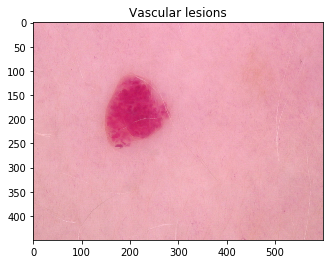

In [19]:
predict_class(img1)

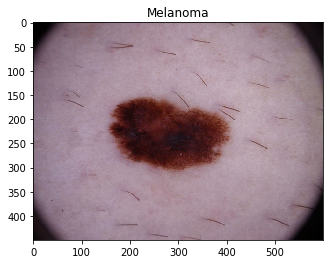

In [20]:
predict_class(img2)

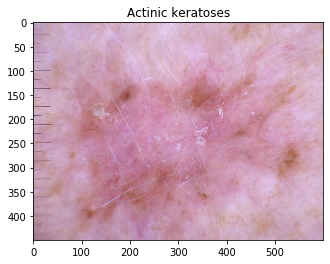

In [21]:
predict_class(img3)